In [2]:
import numpy as np
import sys
import pickle
import pathlib
from os.path import join
path_to_file = str(pathlib.Path().resolve())
dir_path = join(path_to_file, "../../")


sys.path.append(join(dir_path, "HelperFiles"))
from helper import *
from rankshap import *
from train_models import *
from load_data import *

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import shap
import pandas as pd
X_display, y_display = shap.datasets.adult(display=True)
colnames = X_display.columns
d = len(colnames)
# dataset = sys.argv[1]
# K = int(sys.argv[2])
dataset = "census"
data_path = join(dir_path, "Experiments", "Data")
X_train, y_train, X_test, y_test, mapping_dict = load_data(data_path, dataset)

model = train_neural_net(X_train, y_train)

/Users/jeremygoldwasser/opt/anaconda3/envs/shap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
np.random.seed(1)
K = 5
i = 2
# i = 8 # 3% FWER, k=2
xloc = X_test[i:(i+1)]
shap_vals_all = []
lengths = []
top_K = []
N_runs = 10
while len(top_K) < N_runs:
    shap_vals, diffs, converged = rankshap(model, X_train, xloc, K=K, alpha=0.2, 
                            mapping_dict=mapping_dict, max_n_perms=10000, n_init=100, n_equal=False)
    if converged:
        est_top_K = get_ranking(shap_vals)[:K]
        top_K.append(est_top_K)
        lens = [len(diffs[j]) for j in range(d)]
        lengths.append(lens)
        if len(lengths) % 2 == 0:
            print(len(lengths))

# Compute FWER
print(np.round(calc_fwer(top_K)*100, 1))

2
4
6
8
10
0.0


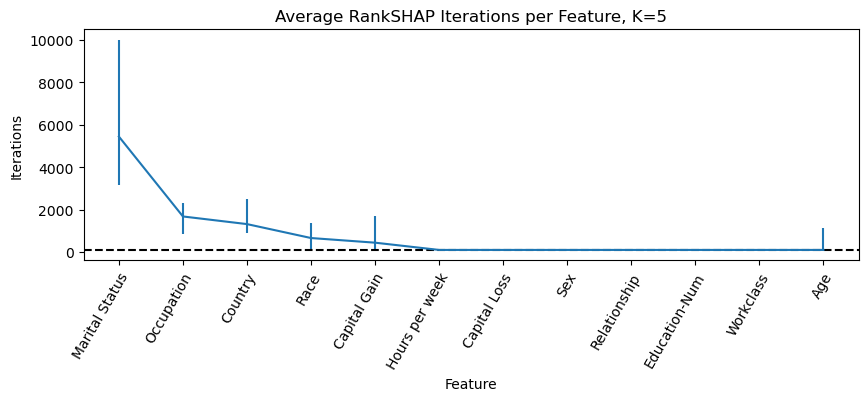

In [4]:
lengths = np.array(lengths)
meds = np.median(lengths, axis=0)
q1 = np.quantile(lengths, .25, axis=0)
q3 = np.quantile(lengths, .75, axis=0)
q1_err = meds - q1
q3_err = q3 - meds

order = get_ranking(meds)

plt.figure(figsize=(10,3))
plt.errorbar(colnames[order], meds[order], yerr = [q1_err[order], q3_err[order]])
plt.xticks(np.arange(d), colnames[order], rotation=60, rotation_mode='anchor', ha="right")
plt.axhline(100, color="black", linestyle="dashed")
plt.xlabel("Feature")
plt.ylabel("Iterations")
plt.title("Average RankSHAP Iterations per Feature, K=5")
plt.savefig(join(dir_path, "Experiments", "Figures", "iters.png"))
plt.show()